In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [248]:
df=pd.read_csv('/finalproject/cleaning_process/hospital_data_cleaned.csv')

C:\Users\TottaraDhanush\AppData\Local\Temp\ipykernel_14592\4255619362.py:1: DtypeWarning: Columns (23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('/finalproject/cleaning_process/hospital_data_cleaned.csv')


In [ ]:

# Basic info
print(f"Dataset shape: {df.shape}")
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

# Convert to datetime
df['ResidentDate'] = pd.to_datetime(df[['ResidentDate_year','ResidentDate_month','ResidentDate_day']].rename(columns={
    'ResidentDate_year':'year',
    'ResidentDate_month':'month',
    'ResidentDate_day':'day'
}))
df['DischargeDate'] = pd.to_datetime(df[['DischargeDate_year','DischargeDate_month','DischargeDate_day']].rename(columns={
    'DischargeDate_year':'year',
    'DischargeDate_month':'month',
    'DischargeDate_day':'day'
}))

# Calculate length of stay
df['LengthOfStay_hours'] = (df['DischargeDate'] - df['ResidentDate']).dt.total_seconds()/3600

Dataset shape: (143280, 25)

Data types:
 DischargeFromED             int64
Foreigners                 object
gender                     object
age                       float64
marital_Status            float64
ResidentDate_year           int64
ResidentDate_month          int64
ResidentDate_day            int64
ResidentDate_weekday        int64
ResidentDate_hour           int64
DischargeDate_year          int64
DischargeDate_month         int64
DischargeDate_day           int64
DischargeDate_weekday       int64
StatusOnDischarge           int64
KindRef                     int64
AccompainerRelation_id    float64
ResidentDay               float64
ResidentDate               object
temperature_max           float64
temperature_min           float64
precipitation             float64
event_type                 object
pandemic                   object
disaster                   object
dtype: object

Missing values:
 DischargeFromED                0
Foreigners                     0
gender    

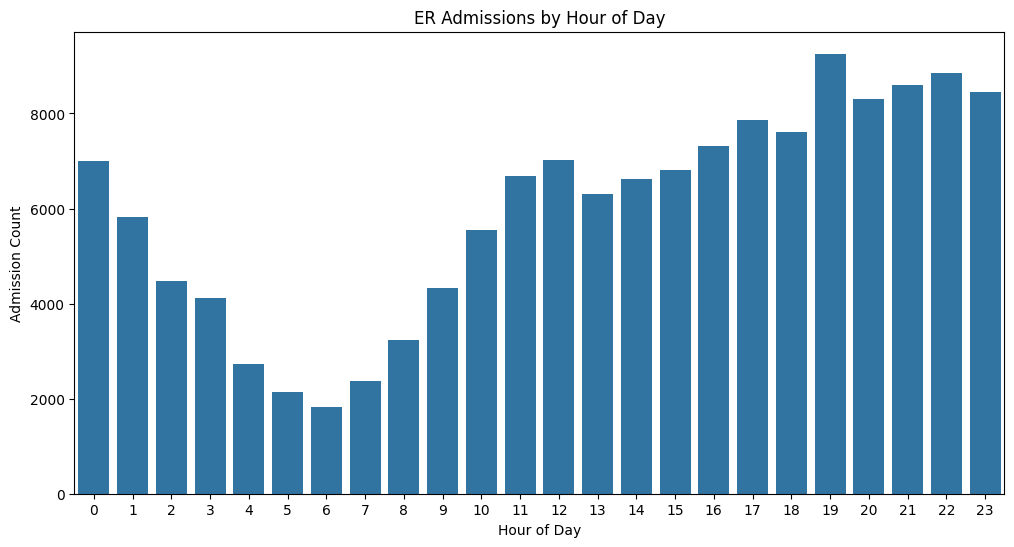

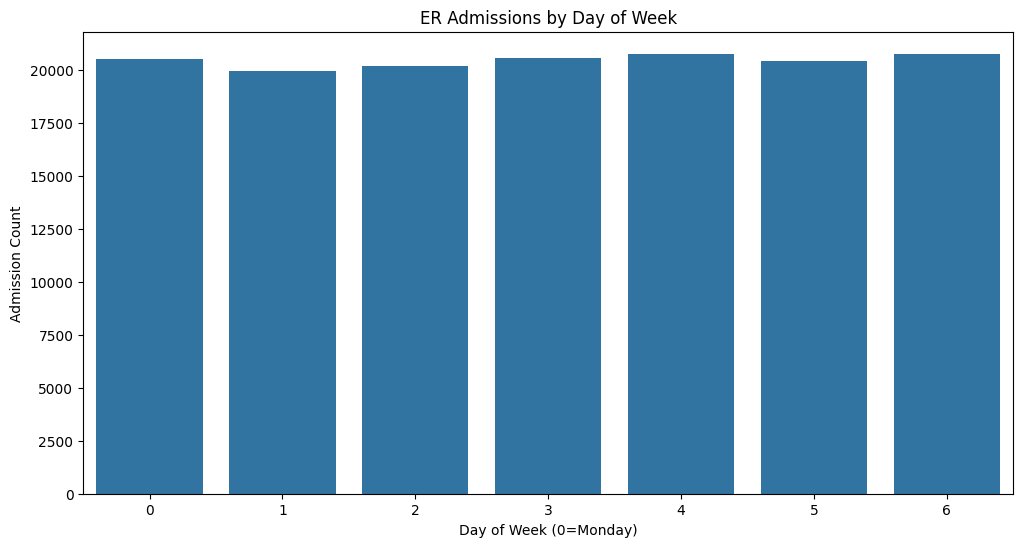

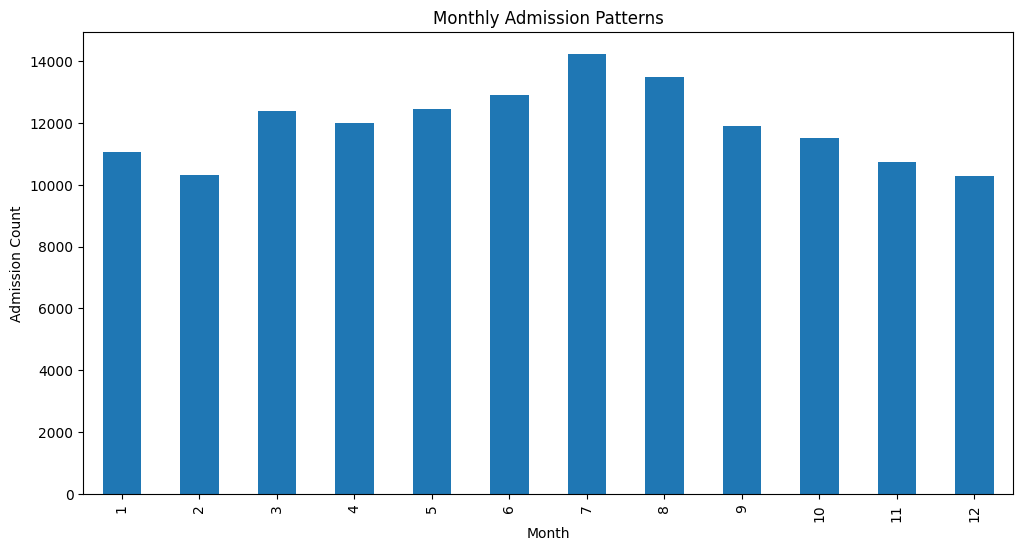

In [250]:
# Hourly admission patterns
plt.figure(figsize=(12,6))
sns.countplot(x='ResidentDate_hour', data=df)
plt.title('ER Admissions by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Admission Count')
plt.show()

# Weekly patterns
plt.figure(figsize=(12,6))
sns.countplot(x='ResidentDate_weekday', data=df)
plt.title('ER Admissions by Day of Week')
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('Admission Count')
plt.show()

# Monthly patterns
monthly_admissions = df.groupby('ResidentDate_month')['DischargeFromED'].count()
monthly_admissions.plot(kind='bar', figsize=(12,6))
plt.title('Monthly Admission Patterns')
plt.xlabel('Month')
plt.ylabel('Admission Count')
plt.show()

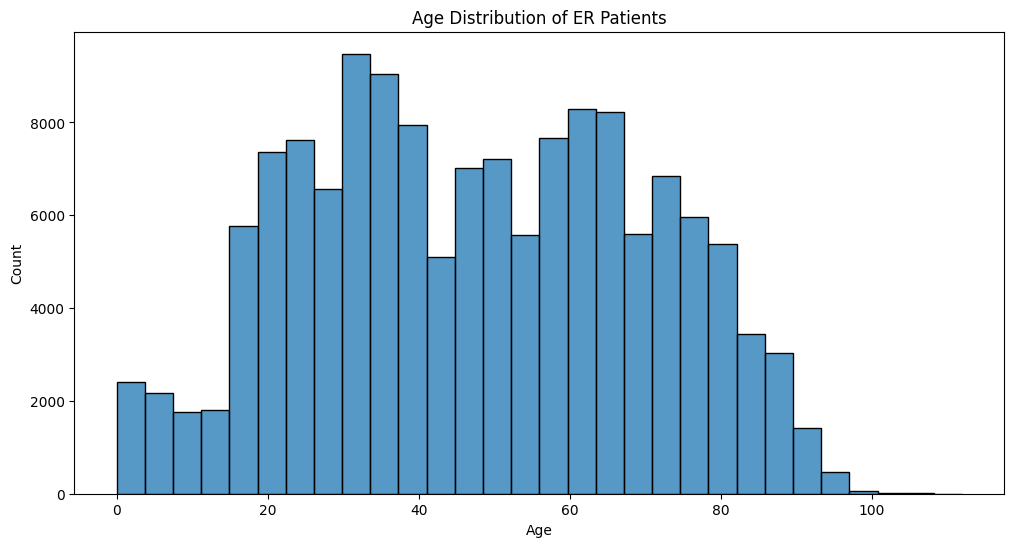

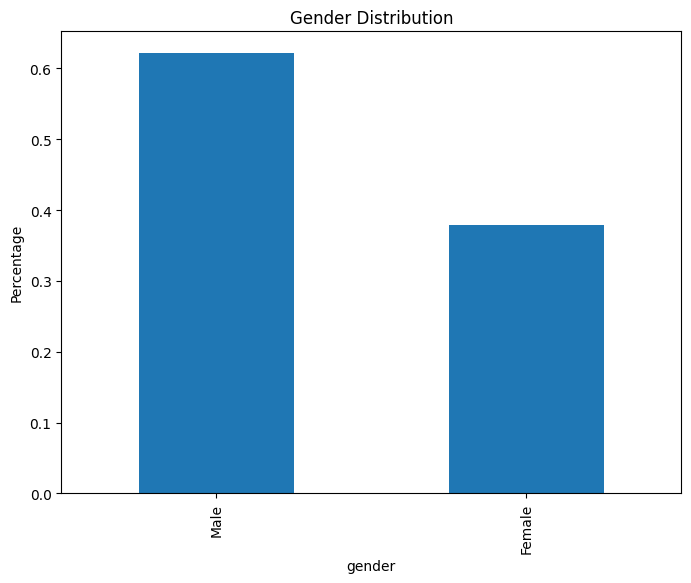

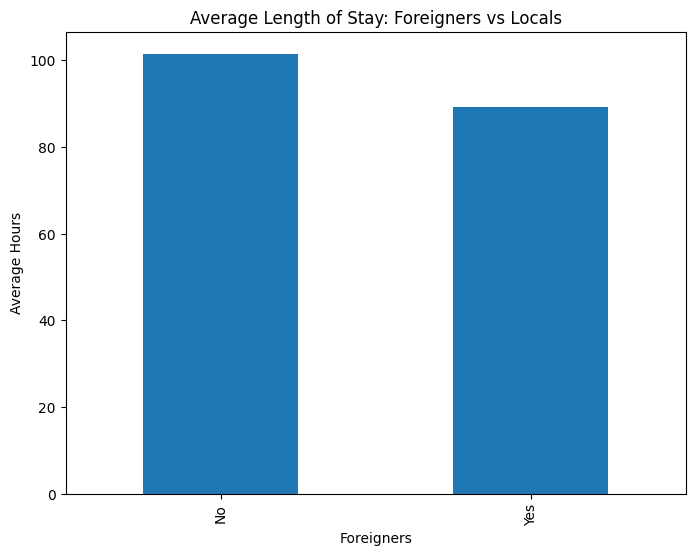

In [251]:
# Age distribution
plt.figure(figsize=(12,6))
sns.histplot(df['age'], bins=30)
plt.title('Age Distribution of ER Patients')
plt.xlabel('Age')
plt.show()

# Gender distribution
gender_dist = df['gender'].value_counts(normalize=True)
gender_dist.plot(kind='bar', figsize=(8,6))
plt.title('Gender Distribution')
plt.ylabel('Percentage')
plt.show()

# Foreigner analysis
foreigner_analysis = df.groupby('Foreigners')['LengthOfStay_hours'].mean()
foreigner_analysis.plot(kind='bar', figsize=(8,6))
plt.title('Average Length of Stay: Foreigners vs Locals')
plt.ylabel('Average Hours')
plt.show()

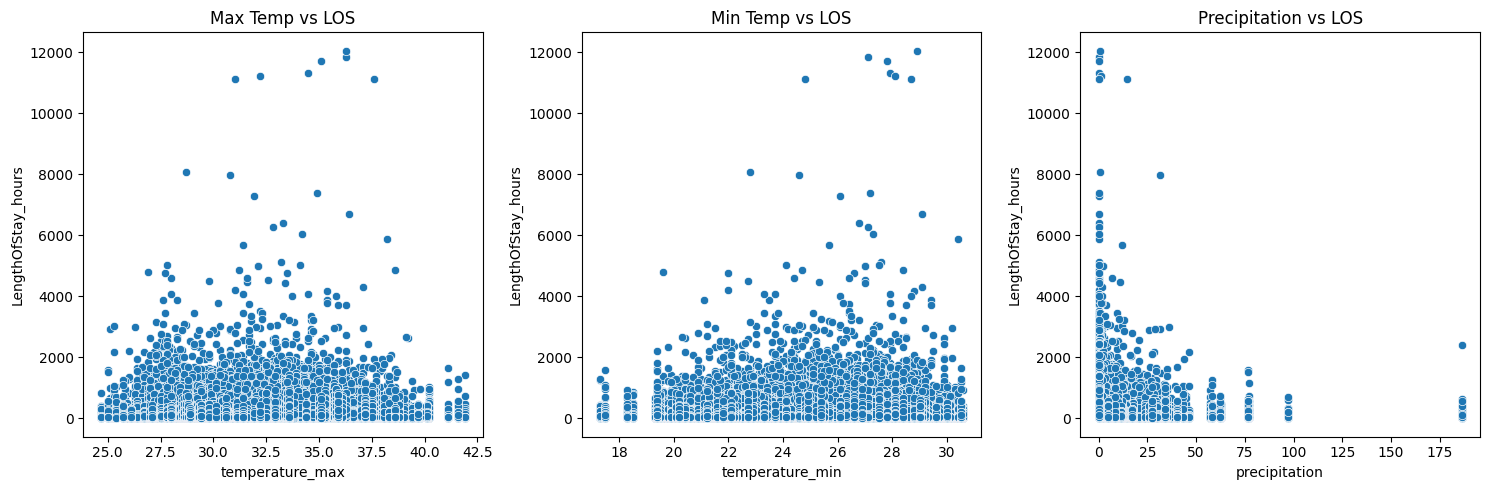

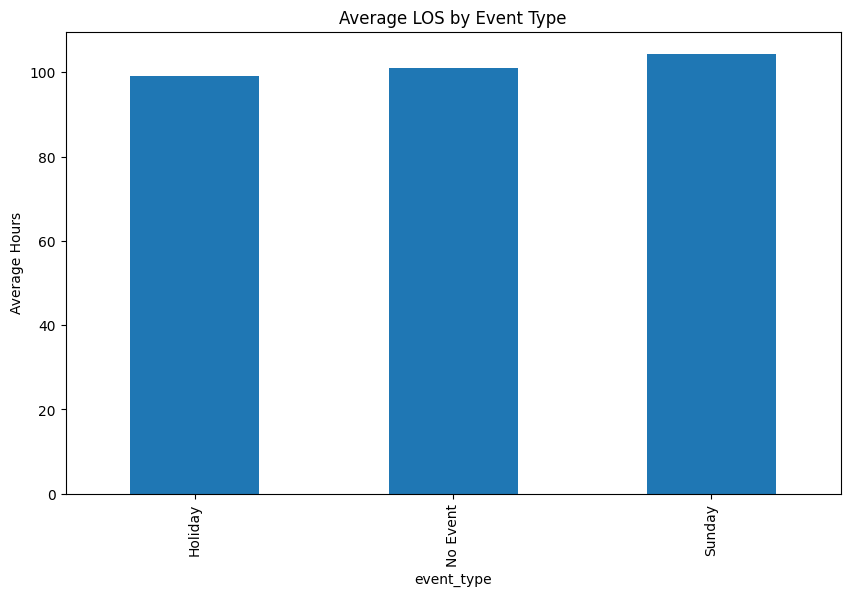

In [252]:
# Weather impact
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.scatterplot(x='temperature_max', y='LengthOfStay_hours', data=df)
plt.title('Max Temp vs LOS')

plt.subplot(1,3,2)
sns.scatterplot(x='temperature_min', y='LengthOfStay_hours', data=df)
plt.title('Min Temp vs LOS')

plt.subplot(1,3,3)
sns.scatterplot(x='precipitation', y='LengthOfStay_hours', data=df)
plt.title('Precipitation vs LOS')
plt.tight_layout()
plt.show()

# Event impact
event_impact = df.groupby('event_type')['LengthOfStay_hours'].mean()
event_impact.plot(kind='bar', figsize=(10,6))
plt.title('Average LOS by Event Type')
plt.ylabel('Average Hours')
plt.show()

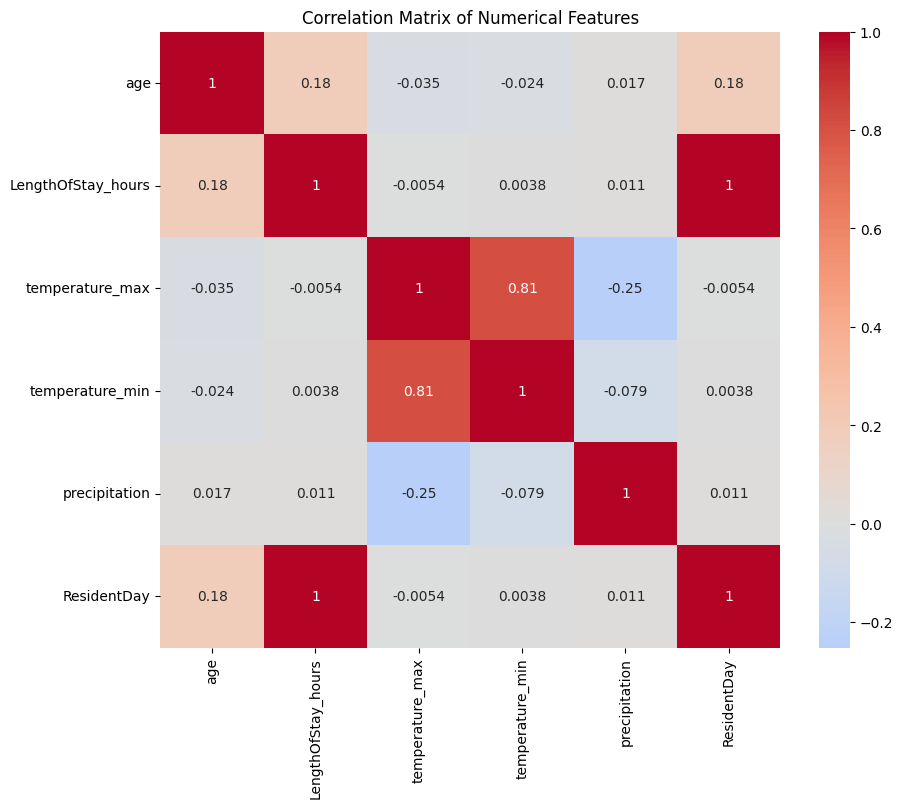

In [253]:
# Select numerical features
numerical_features = ['age', 'LengthOfStay_hours', 'temperature_max', 
                     'temperature_min', 'precipitation', 'ResidentDay']

# Calculate correlations
corr_matrix = df[numerical_features].corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

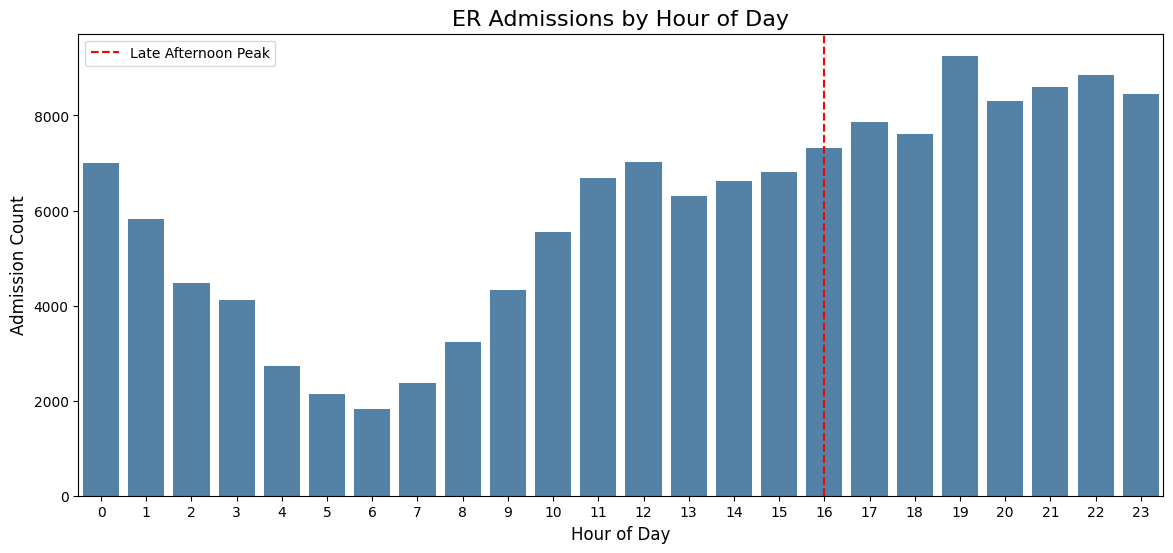

Peak hour admissions: 40353 (28.2%)
Non-peak admissions: 102927 (71.8%)


In [254]:
# Hourly admission patterns
plt.figure(figsize=(14,6))
hourly_counts = df['ResidentDate_hour'].value_counts().sort_index()
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, color='steelblue')
plt.title('ER Admissions by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Admission Count', fontsize=12)
plt.axvline(x=16, color='red', linestyle='--', label='Late Afternoon Peak')
plt.legend()
plt.show()

# Statistical test for peak hours (4pm-8pm) vs non-peak
peak_hours = df['ResidentDate_hour'].between(16, 20)
peak_count = peak_hours.sum()
non_peak_count = len(df) - peak_count
print(f"Peak hour admissions: {peak_count} ({peak_count/len(df)*100:.1f}%)")
print(f"Non-peak admissions: {non_peak_count} ({non_peak_count/len(df)*100:.1f}%)")


Chi-square test: χ²=1.40, p-value=0.2360


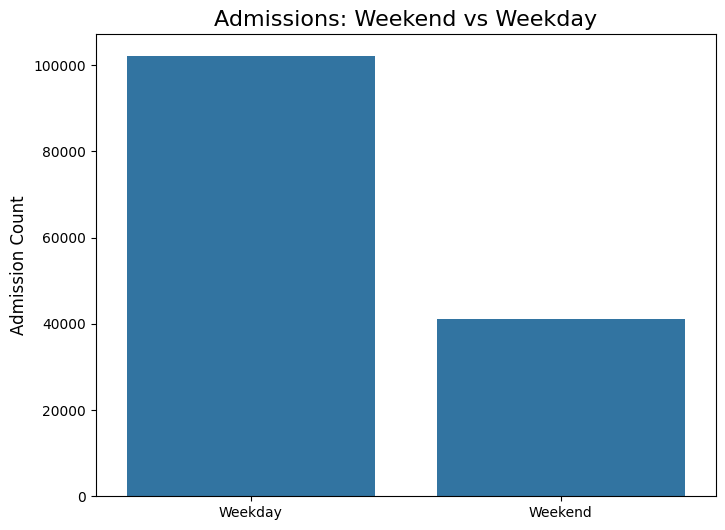

In [255]:
# Weekend vs weekday analysis
df['is_weekend'] = df['ResidentDate_weekday'].isin([5,6]).astype(int)
weekend_counts = df['is_weekend'].value_counts()

plt.figure(figsize=(8,6))
sns.barplot(x=['Weekday', 'Weekend'], y=weekend_counts.values)
plt.title('Admissions: Weekend vs Weekday', fontsize=16)
plt.ylabel('Admission Count', fontsize=12)

# Chi-square test
from scipy.stats import chi2_contingency
observed = weekend_counts.values
expected = [len(df)*5/7, len(df)*2/7]  # 5 weekdays, 2 weekend days
chi2, p, _, _ = chi2_contingency([observed, expected])
print(f"\nChi-square test: χ²={chi2:.2f}, p-value={p:.4f}")


Winter admissions: 31681 (22.1%)
Non-winter admissions: 111599 (77.9%)
Chi-square test: χ²=331.84, p-value=0.0000


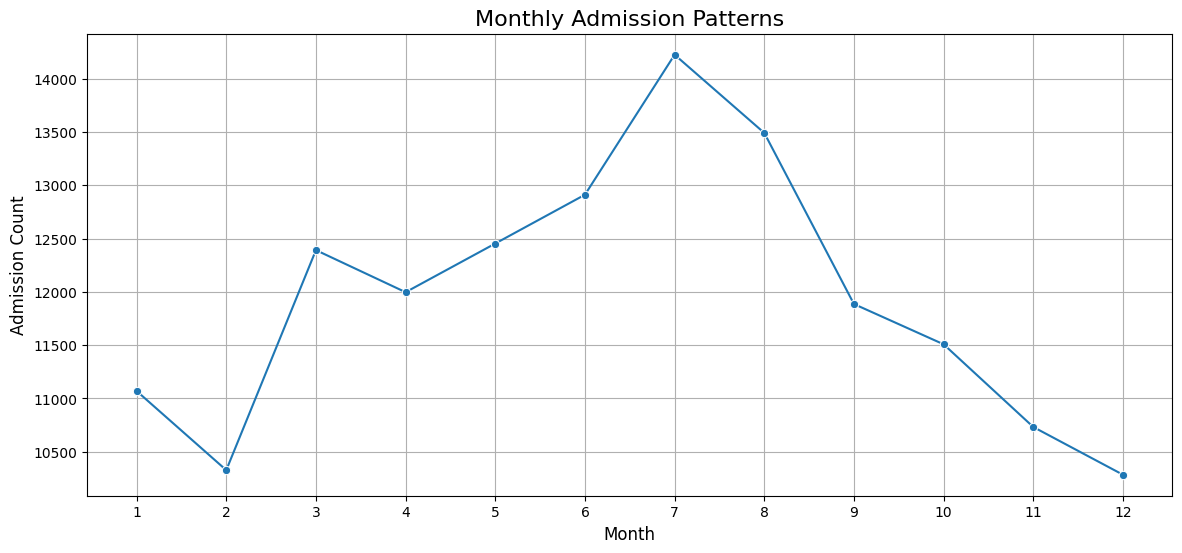

In [256]:
# Monthly admission patterns
plt.figure(figsize=(14,6))
monthly_counts = df['ResidentDate_month'].value_counts().sort_index()
sns.lineplot(x=monthly_counts.index, y=monthly_counts.values, marker='o')
plt.title('Monthly Admission Patterns', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Admission Count', fontsize=12)
plt.xticks(range(1,13))
plt.grid(True)

# Test winter (Dec-Feb) vs non-winter months
winter_months = [12,1,2]
df['is_winter'] = df['ResidentDate_month'].isin(winter_months).astype(int)
winter_counts = df['is_winter'].value_counts()

print(f"\nWinter admissions: {winter_counts[1]} ({winter_counts[1]/len(df)*100:.1f}%)")
print(f"Non-winter admissions: {winter_counts[0]} ({winter_counts[0]/len(df)*100:.1f}%)")

# Chi-square test
observed = winter_counts.values
expected = [len(df)*9/12, len(df)*3/12]  # 3 winter months
chi2, p, _, _ = chi2_contingency([observed, expected])
print(f"Chi-square test: χ²={chi2:.2f}, p-value={p:.4f}")

C:\Users\TottaraDhanush\AppData\Local\Temp\ipykernel_14592\1914002603.py:5: DtypeWarning: Columns (23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('/finalproject/cleaning_process/hospital_data_cleaned.csv')


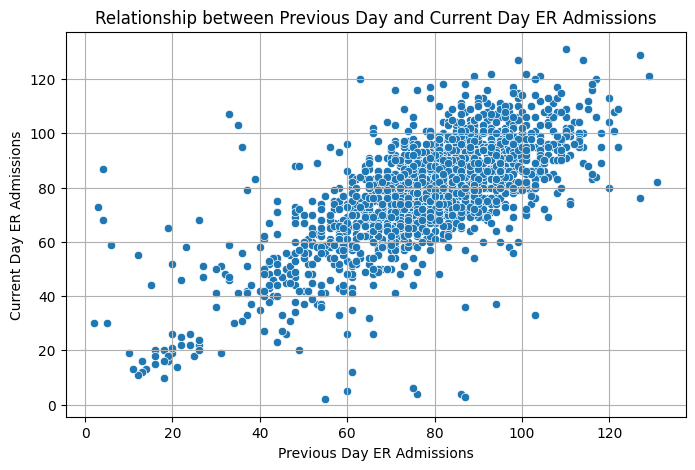

📊 Pearson Correlation: 0.7076 | P-Value: 0.0000
✅ There is a statistically significant relationship between past and current ER admissions.

🔢 Regression Coefficient: 0.7072
Intercept: 23.05


In [257]:

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
 

df=pd.read_csv('/finalproject/cleaning_process/hospital_data_cleaned.csv')
# Convert ResidentDate to datetime
df['ResidentDate'] = pd.to_datetime(df['ResidentDate'])
 
# Group data to daily total admissions
daily_counts = df.groupby('ResidentDate').size().reset_index(name='admissions')
 
# Create Lag Feature (previous day's admissions)
daily_counts['lag_1'] = daily_counts['admissions'].shift(1)
 
# Drop the first row (NaN lag)
daily_counts = daily_counts.dropna()
 
# Plot: Scatter plot to visualize relationship
plt.figure(figsize=(8,5))
sns.scatterplot(x='lag_1', y='admissions', data=daily_counts)
plt.title('Relationship between Previous Day and Current Day ER Admissions')
plt.xlabel('Previous Day ER Admissions')
plt.ylabel('Current Day ER Admissions')
plt.grid(True)
plt.show()
 
# Calculate Correlation
corr, p_value = pearsonr(daily_counts['lag_1'], daily_counts['admissions'])
print(f"📊 Pearson Correlation: {corr:.4f} | P-Value: {p_value:.4f}")
 
if p_value < 0.05:
    print("✅ There is a statistically significant relationship between past and current ER admissions.")
else:
    print("❌ No strong evidence for lag effect.")
 
# Simple Linear Regression to quantify effect
X = daily_counts[['lag_1']]
y = daily_counts['admissions']
model = LinearRegression().fit(X, y)
print(f"\n🔢 Regression Coefficient: {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.2f}")

C:\Users\TottaraDhanush\AppData\Local\Temp\ipykernel_14592\1158750551.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Festival', y='Total_Admissions', data=average_admissions, palette='viridis')


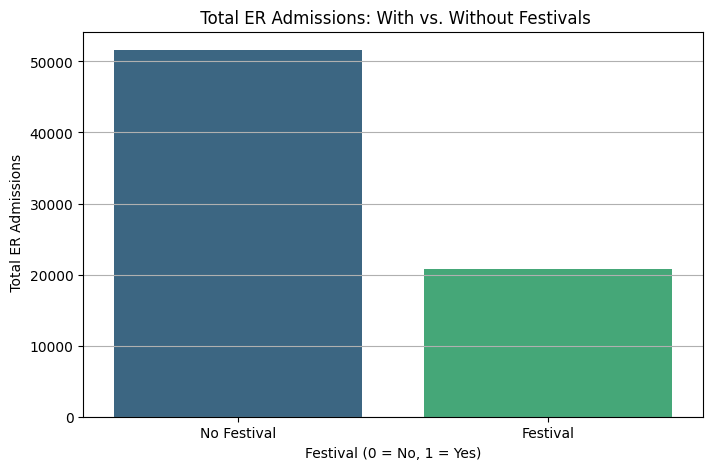

In [258]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
# Load the dataset
df = pd.read_csv('/finalproject/feature_engineering/time_series_data.csv')
 
# Calculate average total admissions based on festival occurrence
average_admissions = df.groupby('Festival')['Total_Admissions'].sum().reset_index()
 
# Create a bar chart to visualize the average total admissions
plt.figure(figsize=(8, 5))
sns.barplot(x='Festival', y='Total_Admissions', data=average_admissions, palette='viridis')
plt.title(' Total ER Admissions: With vs. Without Festivals')
plt.xlabel('Festival (0 = No, 1 = Yes)')
plt.ylabel(' Total ER Admissions')
plt.xticks(ticks=[0, 1], labels=['No Festival', 'Festival'])
plt.grid(axis='y')
plt.show()
 

C:\Users\TottaraDhanush\AppData\Local\Temp\ipykernel_14592\561287776.py:3: DtypeWarning: Columns (23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('/finalproject/cleaning_process/hospital_data_cleaned.csv')


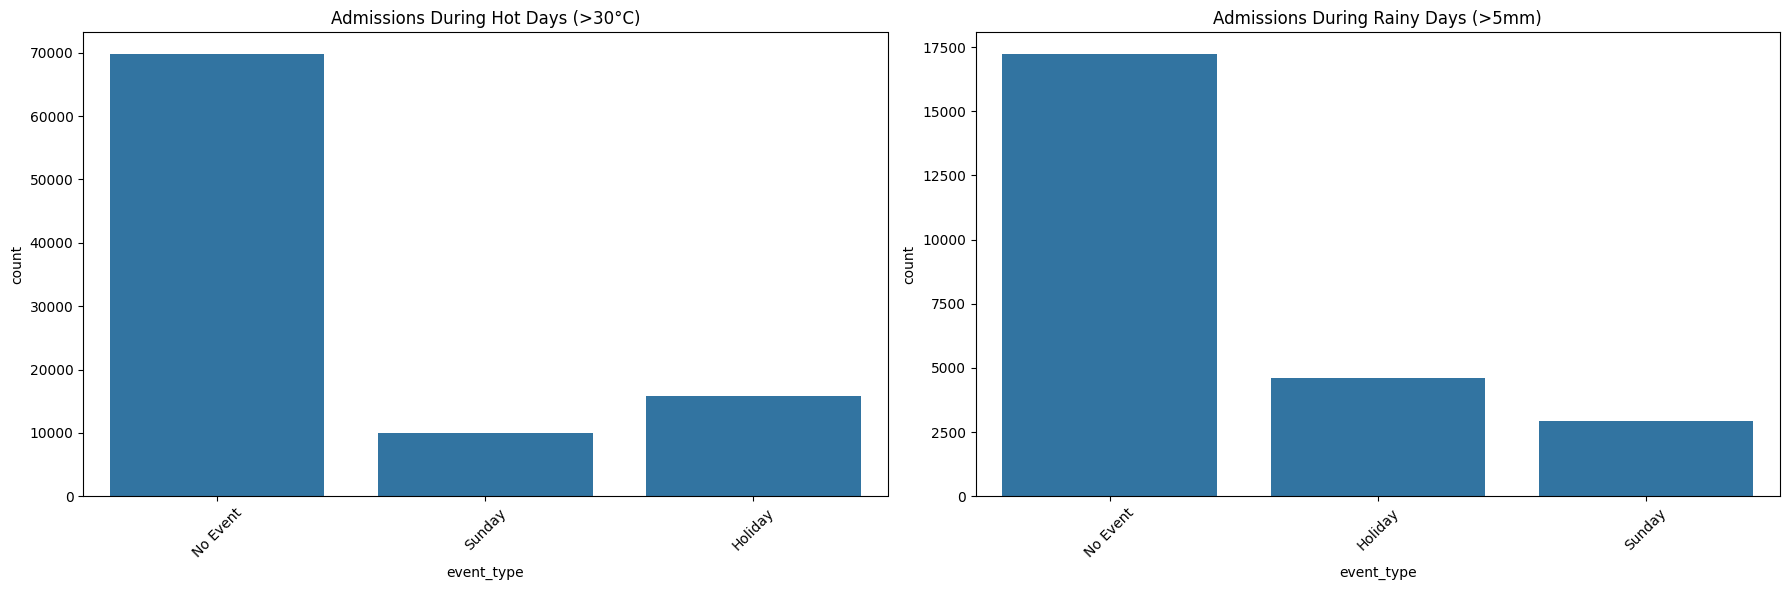

In [259]:
# Weather interaction analysis
fig, axes = plt.subplots(1,2 , figsize=(18,6))
df=pd.read_csv('/finalproject/cleaning_process/hospital_data_cleaned.csv')

# Hot weather and dehydration
hot_days = df[df['temperature_max'] > 30]
sns.countplot(x='event_type', data=hot_days, ax=axes[0])
axes[0].set_title('Admissions During Hot Days (>30°C)')
axes[0].tick_params(axis='x', rotation=45)

# Precipitation and accidents
rainy_days = df[df['precipitation'] > 5]
sns.countplot(x='event_type', data=rainy_days, ax=axes[1])
axes[1].set_title('Admissions During Rainy Days (>5mm)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Admission Count')

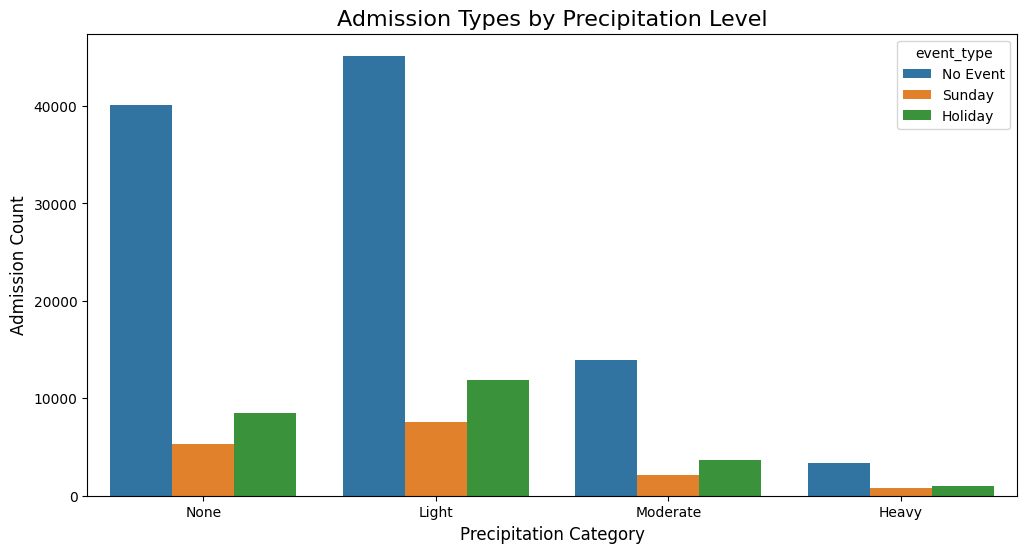

In [260]:
# Precipitation analysis
df['precip_category'] = pd.cut(df['precipitation'],
                              bins=[-1, 0, 5, 20, np.inf],
                              labels=['None', 'Light', 'Moderate', 'Heavy'])

plt.figure(figsize=(12,6))
sns.countplot(x='precip_category', hue='event_type', data=df)
plt.title('Admission Types by Precipitation Level', fontsize=16)
plt.xlabel('Precipitation Category', fontsize=12)
plt.ylabel('Admission Count', fontsize=12)

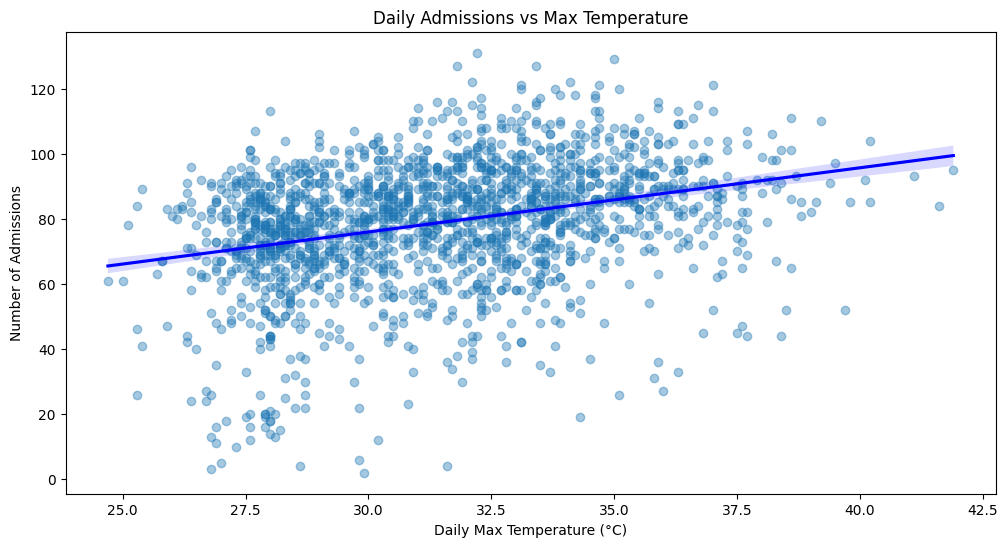

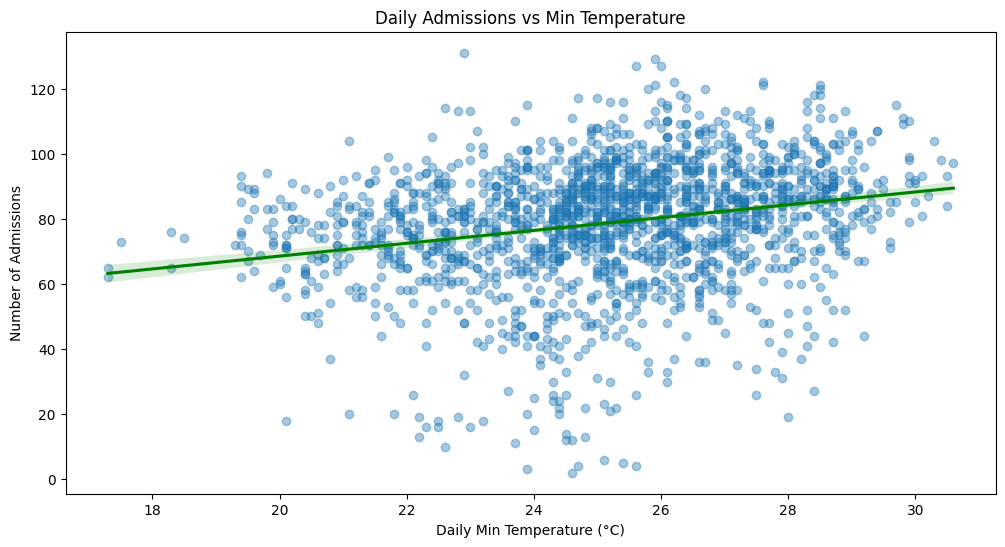

In [270]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



# Ensure ResidentDate is a datetime column
df['ResidentDate'] = pd.to_datetime(df['ResidentDate'])

# Aggregate to daily admissions
daily_admissions = df.groupby(pd.Grouper(key='ResidentDate', freq='D')).agg(
    admissions=('DischargeFromED','count'),
    mean_temp_max=('temperature_max','mean'),
    mean_temp_min=('temperature_min','mean')
).reset_index()

plt.figure(figsize=(12,6))
sns.regplot(x='mean_temp_max', y='admissions', data=daily_admissions,
           scatter_kws={'alpha':0.4}, line_kws={'color':'blue'})
plt.title('Daily Admissions vs Max Temperature')
plt.xlabel('Daily Max Temperature (°C)')
plt.ylabel('Number of Admissions')
plt.show()

plt.figure(figsize=(12,6))
sns.regplot(x='mean_temp_min', y='admissions', data=daily_admissions,
           scatter_kws={'alpha':0.4}, line_kws={'color':'green'})
plt.title('Daily Admissions vs Min Temperature')
plt.xlabel('Daily Min Temperature (°C)')
plt.ylabel('Number of Admissions')
plt.show()


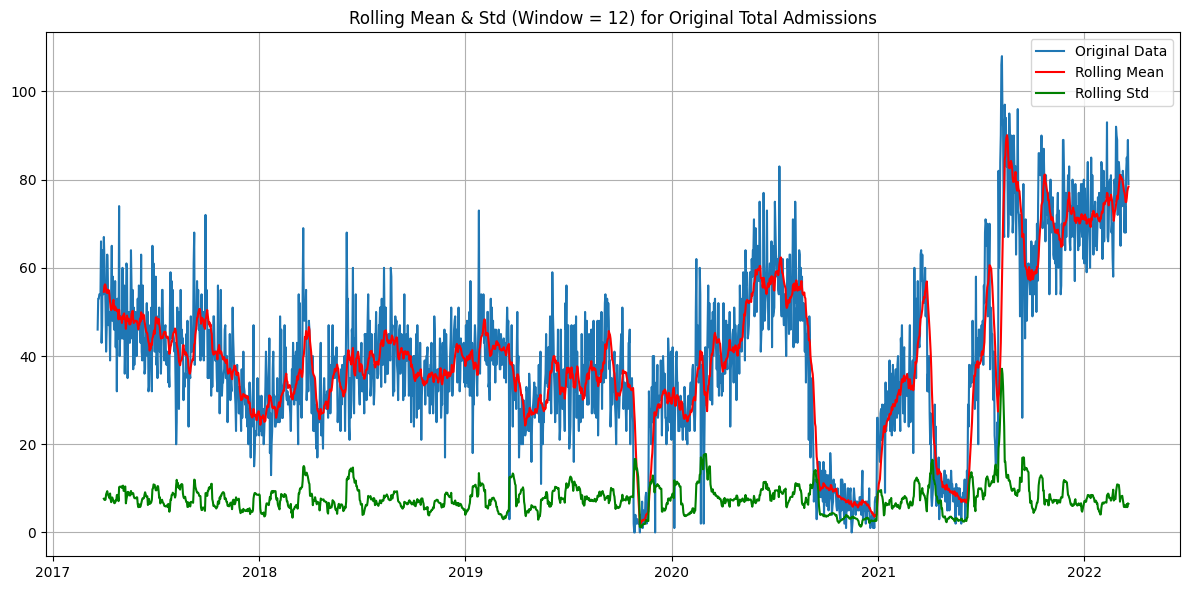

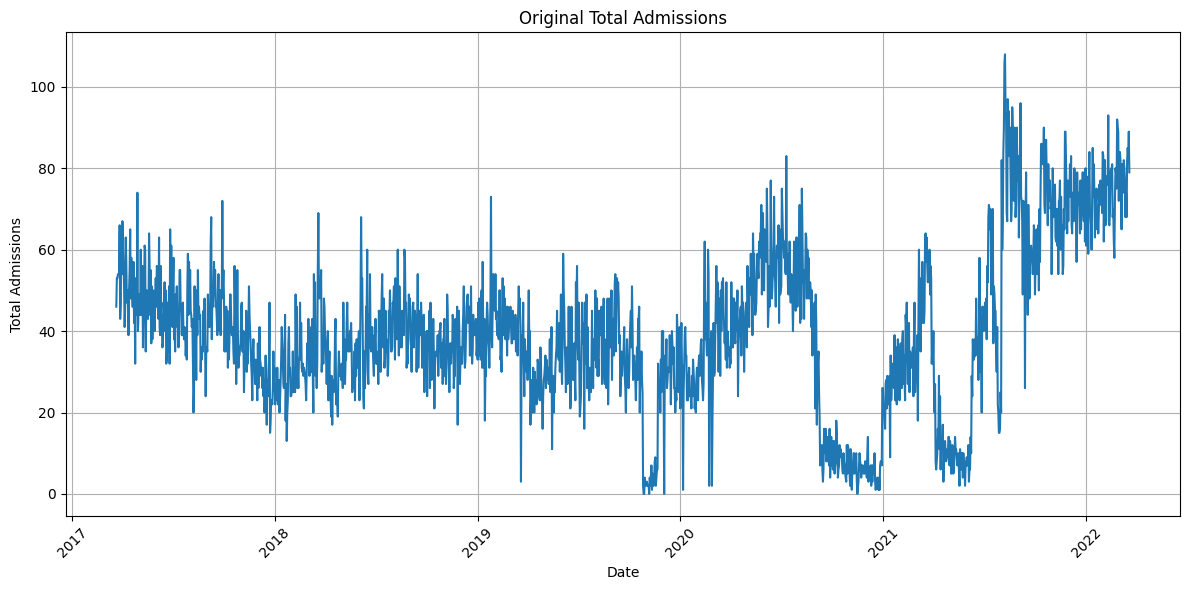

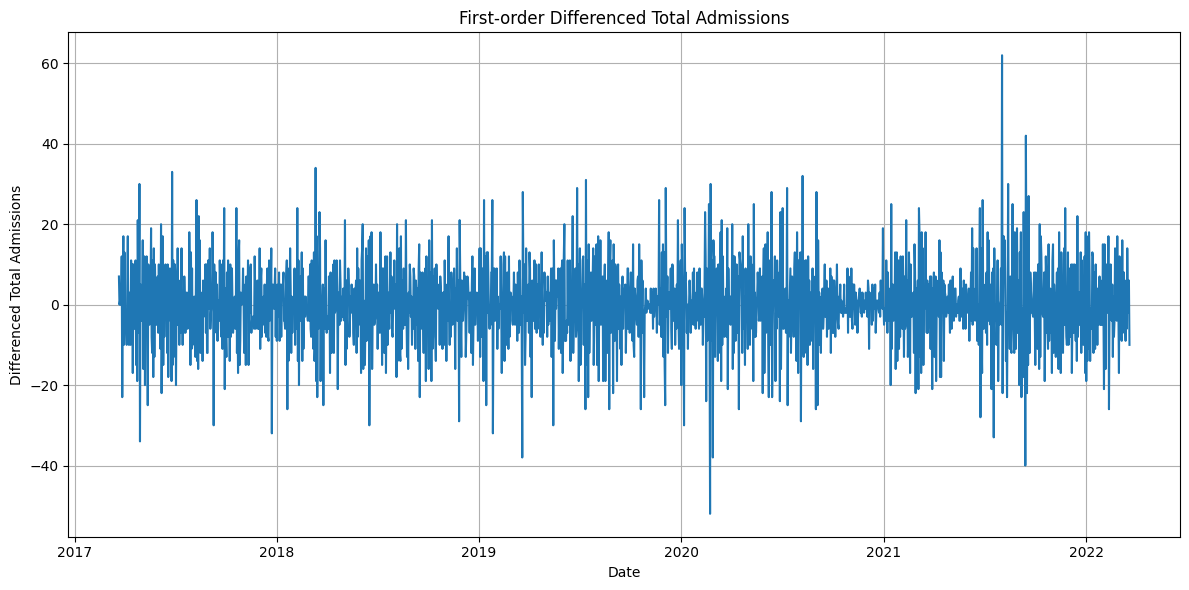

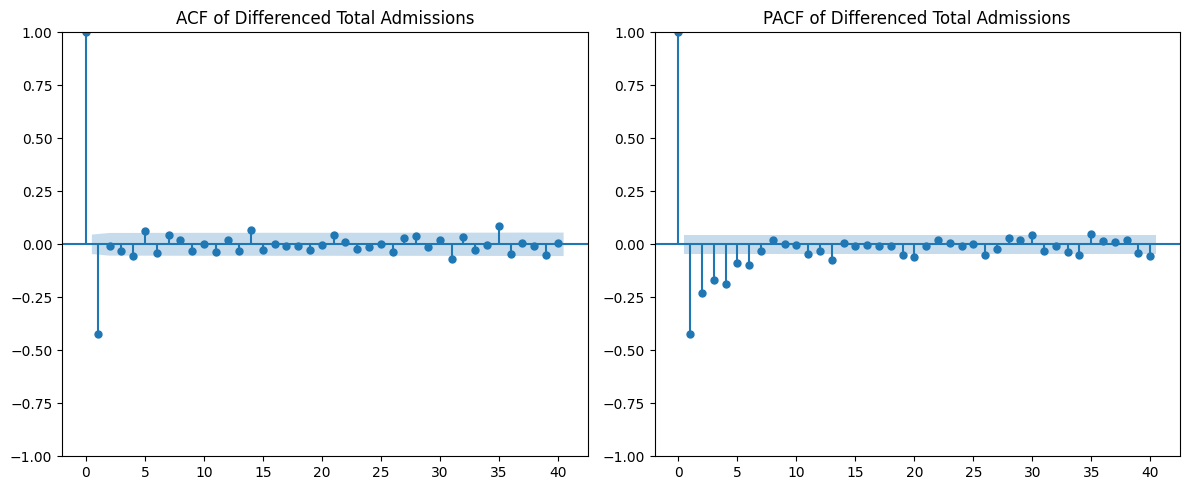

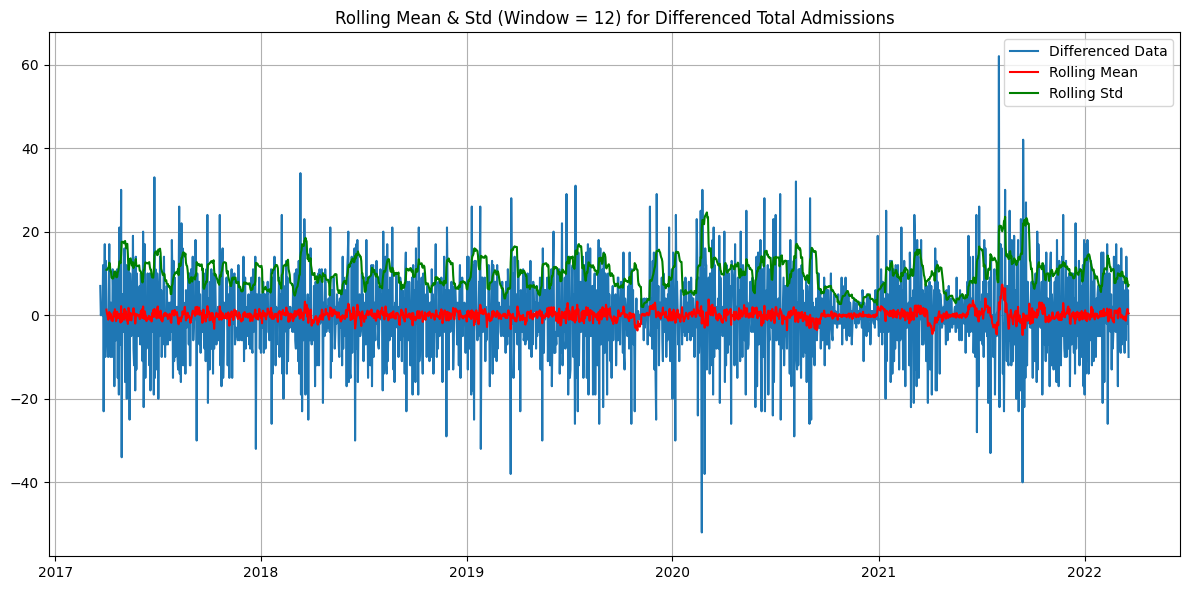

In [278]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
 
# Load data
hospital_data=pd.read_csv('/finalproject/feature_engineering/time_series_data.csv')
hospital_data['ResidentDate'] = pd.to_datetime(hospital_data['ResidentDate'])
 
# Aggregate daily admissions
daily_admissions = hospital_data.groupby('ResidentDate')['Total_Admissions'].sum().reset_index()
 
# Rolling Mean and Std BEFORE differencing
rolling_window = 12
rolling_mean_original = daily_admissions['Total_Admissions'].rolling(window=rolling_window).mean()
rolling_std_original = daily_admissions['Total_Admissions'].rolling(window=rolling_window).std()
 
plt.figure(figsize=(12, 6))
plt.plot(daily_admissions['ResidentDate'], daily_admissions['Total_Admissions'], label='Original Data')
plt.plot(daily_admissions['ResidentDate'], rolling_mean_original, color='red', label='Rolling Mean')
plt.plot(daily_admissions['ResidentDate'], rolling_std_original, color='green', label='Rolling Std')
plt.title(f'Rolling Mean & Std (Window = {rolling_window}) for Original Total Admissions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
 
# First-order differencing
daily_admissions['Total_Admissions_diff'] = daily_admissions['Total_Admissions'].diff()
 
# Plot original data
plt.figure(figsize=(12, 6))
plt.plot(daily_admissions['ResidentDate'], daily_admissions['Total_Admissions'])
plt.title('Original Total Admissions')
plt.xlabel('Date')
plt.ylabel('Total Admissions')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
 
# Plot differenced data
plt.figure(figsize=(12, 6))
plt.plot(daily_admissions['ResidentDate'], daily_admissions['Total_Admissions_diff'])
plt.title('First-order Differenced Total Admissions')
plt.xlabel('Date')
plt.ylabel('Differenced Total Admissions')
plt.grid(True)
plt.tight_layout()
plt.show()
 
# ACF and PACF plots
plt.figure(figsize=(12, 5))
 
plt.subplot(1, 2, 1)
plot_acf(daily_admissions['Total_Admissions_diff'].dropna(), ax=plt.gca(), lags=40)
plt.title('ACF of Differenced Total Admissions')
 
plt.subplot(1, 2, 2)
plot_pacf(daily_admissions['Total_Admissions_diff'].dropna(), ax=plt.gca(), lags=40, method='ywm')
plt.title('PACF of Differenced Total Admissions')
 
plt.tight_layout()
plt.show()
 
# Rolling Mean and Std AFTER differencing
rolling_mean_diff = daily_admissions['Total_Admissions_diff'].rolling(window=rolling_window).mean()
rolling_std_diff = daily_admissions['Total_Admissions_diff'].rolling(window=rolling_window).std()
 
plt.figure(figsize=(12, 6))
plt.plot(daily_admissions['ResidentDate'], daily_admissions['Total_Admissions_diff'], label='Differenced Data')
plt.plot(daily_admissions['ResidentDate'], rolling_mean_diff, color='red', label='Rolling Mean')
plt.plot(daily_admissions['ResidentDate'], rolling_std_diff, color='green', label='Rolling Std')
plt.title(f'Rolling Mean & Std (Window = {rolling_window}) for Differenced Total Admissions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

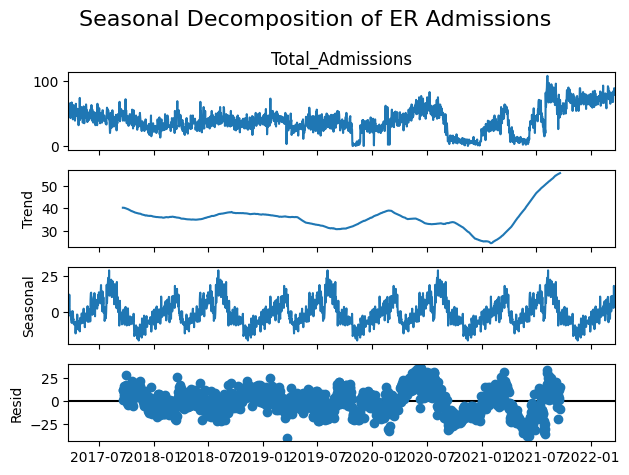

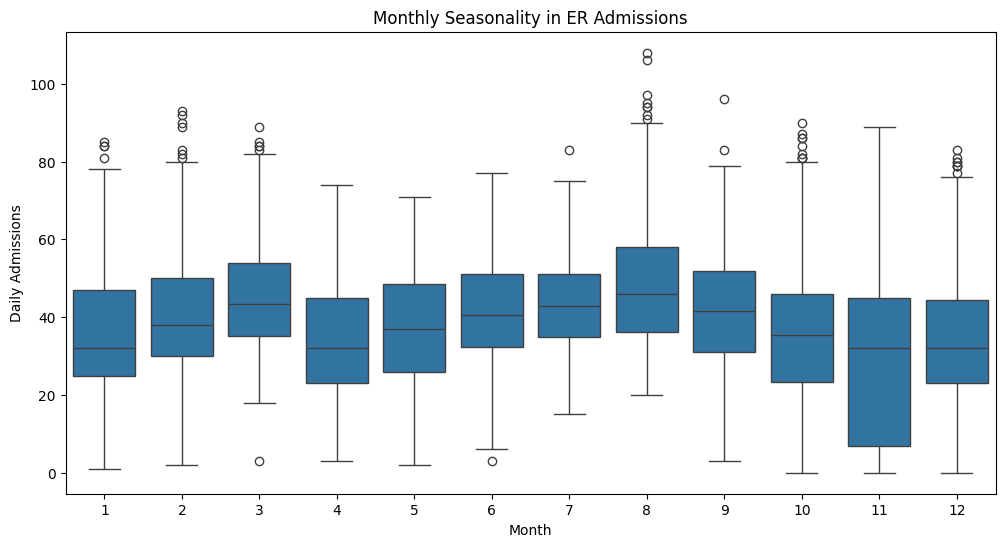

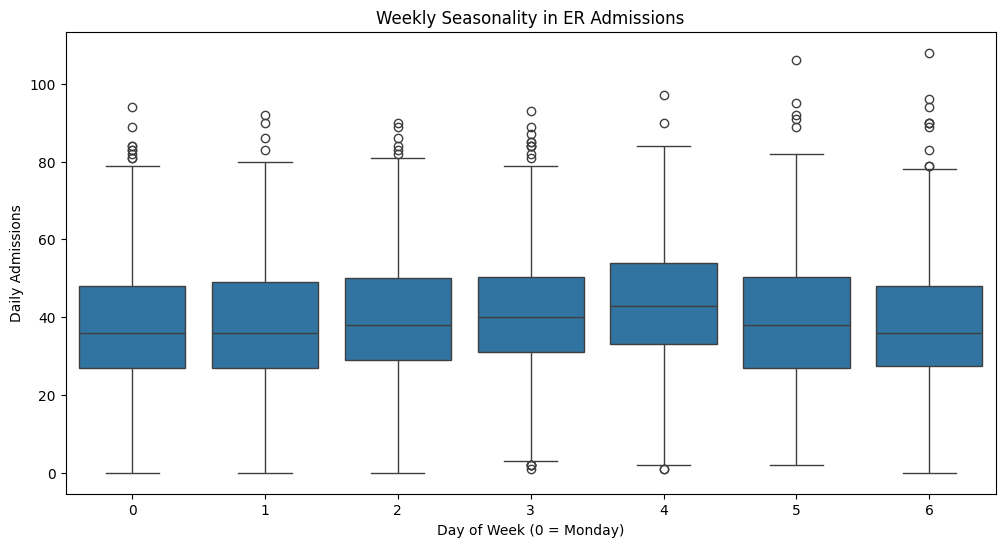

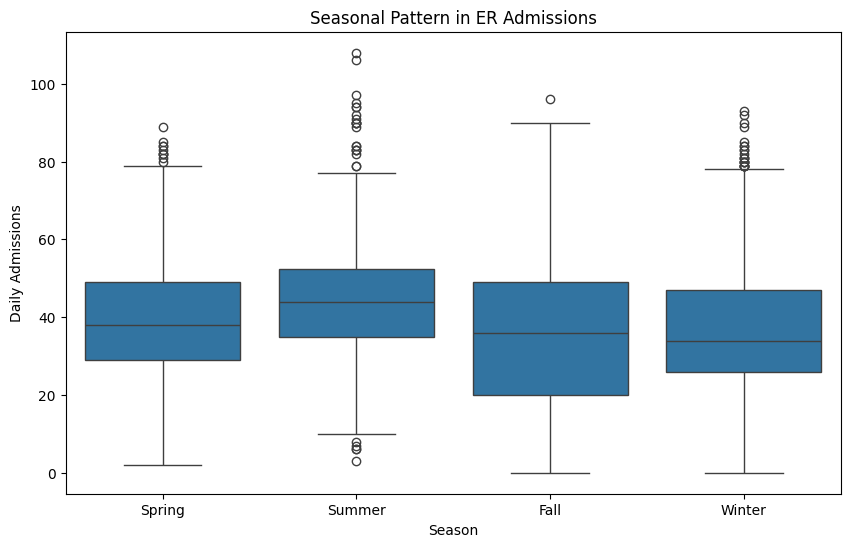

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
 
# Load data
df = pd.read_csv("/finalproject/feature_engineering/time_series_data.csv", parse_dates=["ResidentDate"])
df.set_index("ResidentDate", inplace=True)
 
# ================================
# 1. Seasonal Decomposition
# ================================
result = seasonal_decompose(df['Total_Admissions'], model='additive', period=365)  # yearly seasonality
 
# Plot decomposition
result.plot()
plt.suptitle("Seasonal Decomposition of ER Admissions", fontsize=16)
plt.tight_layout()
plt.show()
 
# ================================
# 2. Admissions by Month
# ================================
plt.figure(figsize=(12,6))
sns.boxplot(x=df.index.month, y='Total_Admissions', data=df)
plt.title("Monthly Seasonality in ER Admissions")
plt.xlabel("Month")
plt.ylabel("Daily Admissions")
plt.show()
 
# ================================
# 3. Admissions by Weekday
# ================================
plt.figure(figsize=(12,6))
sns.boxplot(x='ResidentDate_weekday', y='Total_Admissions', data=df.reset_index())
plt.title("Weekly Seasonality in ER Admissions")
plt.xlabel("Day of Week (0 = Monday)")
plt.ylabel("Daily Admissions")
plt.show()
 
# ================================
# 4. Admissions by Season
# ================================
season_map = {1: "Winter", 2: "Spring", 3: "Summer", 4: "Fall"}
df['season_name'] = df['season'].map(season_map)
 
plt.figure(figsize=(10,6))
sns.boxplot(x='season_name', y='Total_Admissions', data=df)
plt.title("Seasonal Pattern in ER Admissions")
plt.xlabel("Season")
plt.ylabel("Daily Admissions")
plt.show()
 